Create Network
===

In [52]:
%matplotlib inline

import os
import re
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

from collections import Counter
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle
import itertools

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [2]:
data_dir = "/home/levon003/repos/sna-social-support/network_data"
assert os.path.exists(data_dir)

In [3]:
!ls {data_dir}

amps.csv  gb.csv  jr.csv  pcts.csv


In [7]:
import redis

In [8]:
# can store key-value pairs in a running Redis server
r = redis.Redis(host='localhost', port=6379, db=0)
r

Redis<ConnectionPool<Connection<host=localhost,port=6379,db=0>>>

## User analysis

In [3]:
users = pd.read_csv(os.path.join(data_dir, "pcts.csv"))
len(users)

601189

In [4]:
users.head()

,userId,siteId,numJournals,pctJournals
0,0,0,0,0.000000
1,0,100020,47,0.000043
2,0,100459,54,0.000050
3,0,100508,130,0.000120
4,0,100854,2,0.000002


In [5]:
users.drop(users[users.userId == 0].index, inplace=True)
len(users)

591394

In [6]:
print(f"Num users: {len(set(users.userId))}")
print(f"Num sites: {len(set(users.siteId))}")

Num users: 566078
Num sites: 530841


In [9]:
missing_author_info_count = 0
multiple_users_count = 0
for siteId, group in tqdm(users.groupby(by='siteId', sort=False)):
    site_pct_total = np.sum(group.pctJournals)
    if not np.isclose(site_pct_total, 1):
        missing_author_info_count += 1
    if len(group) > 1:
        multiple_users_count += 1
print(f"{missing_author_info_count} sites have some journals with unknown author ({missing_author_info_count / len(set(users.siteId)) * 100}%).")
print(f"{multiple_users_count} sites have multiple contributing authors ({multiple_users_count / len(set(users.siteId)) * 100}%).")

100%|██████████| 530841/530841 [02:53<00:00, 3056.46it/s]


82423 sites have some journals with unknown author (15.52687151143186%).
45374 sites have multiple contributing authors (8.547568857718224%).


In [10]:
multiple_sites_count = 0
for userId, group in tqdm(users.groupby(by='userId', sort=False)):
    if len(group) > 1:
        multiple_sites_count += 1
print(f"{multiple_sites_count} users contributed to multiple sites ({multiple_sites_count / len(set(users.userId)) * 100}%).")

100%|██████████| 566078/566078 [01:05<00:00, 8630.53it/s]

18616 users contributed to multiple sites (3.2885927381032296%).


### Site to user dictionary

In [14]:
for siteId, group in tqdm(users.groupby(by='siteId', sort=False)):
    #userIds = tuple(group.userId.tolist())
    # insert to redis
    r.set(str(siteId), ",".join([str(userId) for userId in group.userId.values]))
r.save()

100%|██████████| 530841/530841 [02:17<00:00, 3858.66it/s]


In [ ]:
site_user_map = {}
for siteId, group in tqdm(users.groupby(by='siteId', sort=False)):
    userIds = tuple(group.userId.tolist())
    site_user_map[siteId] = userIds

## Journal Replies Model

In [41]:
jr = pd.read_csv(os.path.join(data_dir, "jr.csv"))
len(jr)

16032646

In [42]:
jr.head()

,from_userId,siteId,to_userID,connectionType,createdAt
0,27249122,10560,387430,reply,1.432177e+12
1,30066560,23,25,reply,1.422675e+12
2,32513369,38,40,reply,1.457715e+12
3,4403066,50,54,reply,1.423975e+12
4,60403,93,685473,reply,1.422856e+12


In [43]:
# Trim to only authors
jr.drop(jr[~jr.from_userId.isin(set(users.userId))].index, inplace=True)
len(jr)

727196

In [44]:
len(set(jr.from_userId)) / len(set(users.userId))

0.1935139680397401

In [45]:
import networkx as nx

In [59]:
G = nx.DiGraph()
nodes = list(set(jr.from_userId))
G.add_nodes_from(nodes)
len(G)

109544

In [55]:
edges = []
for fromUser, siteId in tqdm(jr[['from_userId', 'siteId']].values):
    toUsers = site_user_map[siteId]
    for toUser in toUsers:
        edges.append((fromUser, toUser))

edges.sort()
unique_edges = []
for key, group in itertools.groupby(edges):
    edge_weight = sum(1 for item in group)
    weighted_edge = (key[0], key[1], {'weight': edge_weight})
    unique_edges.append(weighted_edge)

assert len(unique_edges) < len(edges)
len(unique_edges)


100%|██████████| 727196/727196 [00:01<00:00, 466644.32it/s]

280019

In [60]:
G.add_edges_from(unique_edges)
len(G)

142039

In [78]:
scc_sizes = []
for i, connected_nodes in enumerate(sorted(nx.strongly_connected_components(G), key=len, reverse=True)):
    scc_size = len(connected_nodes)
    scc_sizes.append(scc_size)
    update_dict = {}
    for node in connected_nodes:
        update_dict[node] = {"scc": i, "scc_size": scc_size}
    nx.set_node_attributes(G, update_dict)

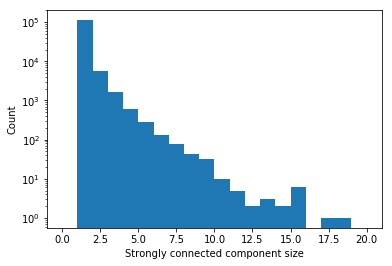

In [86]:
plt.hist(scc_sizes, log=True, bins=20, range=(0,20))
plt.xlabel("Strongly connected component size")
plt.ylabel("Count")
plt.show()

In [79]:
G.nodes[3145728], G.edges[(28098972, 28022476)]

({'scc': 16483, 'scc_size': 1}, {'weight': 25})

In [80]:
static_gexf_filename = "static_journal_replies.gexf"
nx.write_gexf(G, os.path.join(data_dir, static_gexf_filename))

In [92]:
largestScc_G = G.subgraph(sorted(nx.strongly_connected_components(G), key=len, reverse=True)[0])
len(largestScc_G), len(G)
static_gexf_filename = "static_journal_replies_largestscc.gexf"
nx.write_gexf(largestScc_G, os.path.join(data_dir, static_gexf_filename))

In [74]:
# preview the gexf...
for i, line in enumerate(nx.generate_gexf(G)):
    if i > 20:
        break
    print(line)

<gexf version="1.2" xmlns="http://www.gexf.net/1.2draft" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.w3.org/2001/XMLSchema-instance">
  <graph defaultedgetype="directed" mode="static" name="">
    <attributes class="node" mode="static">
      <attribute id="0" title="scc" type="long" />
      <attribute id="1" title="scc_size" type="long" />
    </attributes>
    <meta>
      <creator>NetworkX 2.2</creator>
      <lastmodified>15/02/2019</lastmodified>
    </meta>
    <nodes>
      <node id="3145728" label="3145728">
        <attvalues>
          <attvalue for="0" value="8861" />
          <attvalue for="1" value="1" />
        </attvalues>
      </node>
      <node id="1048579" label="1048579">
        <attvalues>
          <attvalue for="0" value="8864" />
          <attvalue for="1" value="1" />


In [94]:
indegrees = [in_degree for node, in_degree in largestScc_G.in_degree()]
outdegrees = [out_degree for node, out_degree in largestScc_G.out_degree()]
assert len(indegrees) == len(outdegrees)

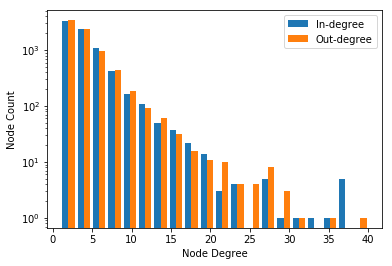

In [98]:
plt.hist([indegrees, outdegrees], log=True, label=["In-degree", "Out-degree"], bins=20, range=(1,40))
plt.ylabel("Node Count")
plt.xlabel("Node Degree")
plt.legend()
plt.show()

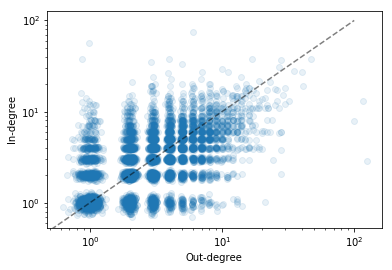

In [144]:
def rand_jitter(arr):
    stdev = 0.1
    return arr + np.random.randn(len(arr)) * stdev

plt.scatter(rand_jitter(outdegrees), rand_jitter(indegrees), alpha=0.1)
plt.plot((0,100), (0, 100), "--", color='black', alpha=0.5)
plt.xlabel("Out-degree")
plt.ylabel("In-degree")
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
#plt.xlim(0, 40)
#plt.ylim(0, 40)
plt.show()

In [131]:
# log of the size of the network approximately predicts the average path length
# true average path length is longer, about 10
np.log(len(largestScc_G))

8.94793610670867